In [57]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import precision_score, recall_score, log_loss, plot_confusion_matrix, accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

In [2]:
X_df = pd.read_csv("Training_set_values.csv")
y_df = pd.read_csv("Training_set_labels.csv")

X_submit = pd.read_csv("Test_set_values.csv")

In [3]:
train_df = pd.merge(y_df, X_df, how='inner', on='id')

In [4]:
train_df['status'] = train_df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})

In [5]:
train_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
59396,27263,functional,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,2
59397,37057,functional,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,...,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2
59398,31282,functional,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2


In [6]:
train_df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [7]:
train_df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [8]:
train_df = train_df.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward', 
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded',
                         'public_meeting',
                         'scheme_management'], axis=1)
                        

In [9]:
train_df = train_df.set_index('id')

In [10]:
num_dict = {}
dfp = train_df.copy().drop(['status_group', 'status'], axis =1)

for x in dfp.columns:
    if dfp[x].dtypes == 'object':
        num_dict[x] = len(dfp[x].value_counts())
num_dict
    

{'funder': 1897,
 'installer': 2145,
 'wpt_name': 37400,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'permit': 2,
 'extraction_type_group': 13,
 'management': 12,
 'payment_type': 7,
 'quality_group': 6,
 'quantity_group': 5,
 'source_type': 7,
 'waterpoint_type_group': 6}

In [11]:
train_df = train_df.drop(['funder','installer','wpt_name','subvillage'], axis=1)

In [12]:
train_df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_group       0
management                  0
payment_type                0
quality_group               0
quantity_group              0
source_type                 0
waterpoint_type_group       0
status                      0
dtype: int64

In [13]:
train_df = train_df.dropna()

In [14]:
train_df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status                   0
dtype: int64

In [15]:
train_df['permit'] = train_df['permit'].astype(int)

In [16]:
X = train_df.drop(['status_group', 'status'], axis=1)
y = train_df['status']

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56344 entries, 69572 to 26348
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             56344 non-null  float64
 1   gps_height             56344 non-null  int64  
 2   longitude              56344 non-null  float64
 3   latitude               56344 non-null  float64
 4   basin                  56344 non-null  object 
 5   region                 56344 non-null  object 
 6   region_code            56344 non-null  int64  
 7   district_code          56344 non-null  int64  
 8   population             56344 non-null  int64  
 9   permit                 56344 non-null  int64  
 10  construction_year      56344 non-null  int64  
 11  extraction_type_group  56344 non-null  object 
 12  management             56344 non-null  object 
 13  payment_type           56344 non-null  object 
 14  quality_group          56344 non-null  object 
 15

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [19]:
X_train_ohe = X_train.select_dtypes('object')
X_train_ohe = pd.concat([X_train_ohe, X_train[['region_code', 'district_code']]], axis=1)
X_test_ohe = X_test.select_dtypes('object')
X_test_ohe = pd.concat([X_test_ohe, X_test[['region_code', 'district_code']]], axis=1)

ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
ohe.fit(X_train_ohe)
X_train_ohe_trans = ohe.transform(X_train_ohe)
X_test_ohe_trans = ohe.transform(X_test_ohe)

train_temp_df = pd.DataFrame(X_train_ohe_trans, columns=ohe.get_feature_names(), index=X_train.index)
test_temp_df = pd.DataFrame(X_test_ohe_trans, columns=ohe.get_feature_names(), index=X_test.index)

X_train_ss = X_train.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)
X_test_ss = X_test.select_dtypes(exclude='object').drop(['permit','region_code','district_code'], axis=1)

ss = StandardScaler()
ss.fit(X_train_ss)
X_train_scaled = ss.transform(X_train_ss)
X_test_scaled = ss.transform(X_test_ss)

train_temp_df1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train_ss.columns)
test_temp_df1 = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test_ss.columns)


train_temp_df2 = X_train[['permit']]
test_temp_df2 = X_test[['permit']]

X_train_clean = pd.concat([train_temp_df1, train_temp_df2, train_temp_df], axis=1)
X_test_clean = pd.concat([test_temp_df1, test_temp_df2, test_temp_df], axis=1)

In [20]:
X_train_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
39029,-0.098932,-0.983487,0.846746,-0.766445,-0.300034,-1.366640,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5015,-0.116706,1.361636,-0.638361,0.360566,0.045715,0.744371,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63663,-0.116706,-0.950192,-0.339696,1.089090,-0.386471,-1.366640,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49199,-0.116706,-0.950192,0.278312,-0.312155,-0.386471,-1.366640,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47678,-0.116706,1.532454,0.389907,0.815197,0.045715,0.734914,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,x0_Lake Nyasa,x0_Lake Rukwa,x0_Lake Tanganyika,...,x10_23,x10_30,x10_33,x10_43,x10_53,x10_60,x10_62,x10_63,x10_67,x10_80
id,,,,,,,,,,,,,,,,,,,,,
39883,-0.116706,-0.950192,-0.359450,1.275847,-0.386471,-1.366640,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59889,0.238777,-0.950192,0.488632,-0.266911,1.134824,0.744371,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12400,-0.116706,-0.950192,-5.057856,1.928976,-0.386471,-1.366640,1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65058,0.238777,1.539692,0.199115,-0.786859,1.018134,0.744371,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1395,-0.106041,-0.893736,0.689792,-0.023396,8.257252,0.741219,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def model_score(model, X, y_predict, y_true):
    acc = accuracy_score(y_predict, y_true)
    rec = recall_score(y_predict, y_true, average='weighted')
    f1 = f1_score(y_predict, y_true, average='weighted')
    prec = precision_score(y_predict, y_true, average='weighted')
    cross = cross_val_score(estimator=model, X=X, y=y_true, cv=10).mean()
    
    print(f' The accuracy score is: {round(acc, 4)}')
    print(f' The cross validation score of accuracy is: {round(cross, 4)}')
    print(f' The recall score is: {round(rec, 4)}')
    print(f' The F1 score is: {round(f1, 4)}')
    print(f' The precision score is: {round(prec, 4)}')
    
    return plot_confusion_matrix(model, X, y_true);

0.444405004880646


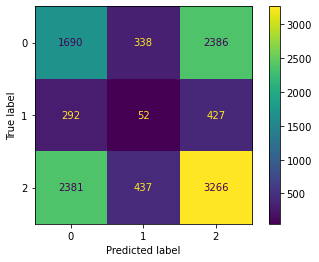

In [23]:
dummy = DummyClassifier(random_state=16)
dummy.fit(X_train_clean, y_train)
print(dummy.score(X_test_clean, y_test))

plot_confusion_matrix(dummy, X_test_clean, y_test);

Training data model score:
 The accuracy score is: 0.7391
 The cross validation score of accuracy is: 0.7375
 The recall score is: 0.7391
 The F1 score is: 0.7661
 The precision score is: 0.8122


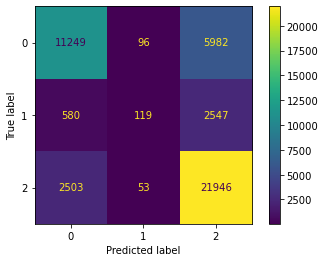

In [24]:
log_model = LogisticRegression(multi_class = "multinomial")
log_model.fit(X_train_clean, y_train)
log_y_pred_train = log_model.predict(X_train_clean)

print("Training data model score:")
log_train_score = model_score(log_model, X_train_clean, log_y_pred_train, y_train)

In [25]:
import statsmodels.api as sm

log_reg = sm.GLM(y_train, X_train_clean).fit()
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                45075
Model:                            GLM   Df Residuals:                    44961
Model Family:                Gaussian   Df Model:                          113
Link Function:               identity   Scale:                         0.58916
Method:                          IRLS   Log-Likelihood:                -51960.
Date:                Wed, 08 Dec 2021   Deviance:                       26469.
Time:                        20:39:02   Pearson chi2:                 2.65e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
amount_tsh                     0.0122      0.004      3.263      0.001       0.005       0.020
gps_height                     0.0254      0.010      2.526      0.012       0.006       0.045
longitude                     -0.0141      0.008     -1.850      0.064      -0.029       0.001
latitude                      -0.0068      0.030     -0.227      0.820      -0.066       0.052
population                     0.0251      0.004      6.338      0.000       0.017       0.033
construction_year             -0.0052      0.012     -0.424      0.672      -0.029       0.019
permit                         0.1365      0.010     13.247      0.000       0.116       0.157
x0_Lake Nyasa                  0.3857      0.042      9.276      0.000       0.304       0.467
x0_Lake Rukwa                 -0.0966      0.038     -2.570      0.010      -0.170      -0.023
x0_Lake Tanganyika             0.0137      0.026      0.521      0.603      -0.038       0.065
x0_Lake Victoria               0.0337      0.027      1.243      0.214      -0.019       0.087
x0_Pangani                    -0.1380      0.029     -4.742      0.000      -0.195      -0.081
x0_Rufiji                      0.1200      0.035      3.474      0.001       0.052       0.188
x0_Ruvuma / Southern Coast     0.2604      0.051      5.102      0.000       0.160       0.360
x0_Wami / Ruvu                 0.0153      0.031      0.492      0.623      -0.046       0.076
x1_Dar es Salaam              -0.2311      0.110     -2.104      0.035      -0.446      -0.016
x1_Dodoma                     -0.4819      0.214     -2.250      0.024      -0.902      -0.062
x1_Iringa                     -0.3464      0.289     -1.197      0.231      -0.914       0.221
x1_Kagera                      0.1095      0.196      0.557      0.577      -0.276       0.495
x1_Kigoma                     -0.4489      0.108     -4.176      0.000      -0.660      -0.238
x1_Kilimanjaro                -0.3068      0.107     -2.870      0.004      -0.516      -0.097
x1_Lindi                      -0.6807      0.159     -4.285      0.000      -0.992      -0.369
x1_Manyara                    -0.2493      0.107     -2.331      0.020      -0.459      -0.040
x1_Mara                       -0.5657      0.109     -5.191      0.000      -0.779      -0.352
x1_Mbeya                      -0.4034      0.110     -3.667      0.000      -0.619      -0.188
x1_Morogoro                   -0.4543      0.133     -3.413      0.001      -0.715      -0.193
x1_Mtwara                     -0.4376      0.138     -3.162      0.002      -0.709      -0.166
x1_Mwanza                     -0.2949      0.170     -1.737      0.082      -0.628       0.038
x1_Pwani                      -0.0256      0.206     -0.124      0.901      -0.429       0.377
x1_Rukwa                      -0.4074      

In [26]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors' : [5, 11, 21, 31, 41]
}
# knn_grid_search = GridSearchCV(knn, grid, cv=3)
# knn_grid_search.fit(X_train_clean, y_train)

# knn_grid_search.best_params_

In [27]:
knn = KNeighborsClassifier()
grid = {
    'n_neighbors' : [1, 3, 5, 7, 9]
}
# knn_grid_search = GridSearchCV(knn, grid, cv=3)
# knn_grid_search.fit(X_train_clean, y_train)

# knn_grid_search.best_params_

Training data model score:
 The accuracy score is: 0.8159
 The cross validation score of accuracy is: 0.7636
 The recall score is: 0.8159
 The F1 score is: 0.8209
 The precision score is: 0.8297


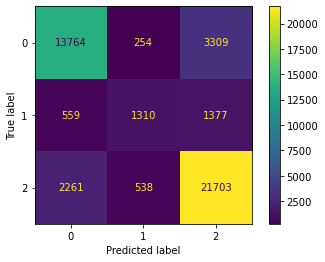

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_clean, y_train)
knn_model_pred = knn_model.predict(X_train_clean)

print("Training data model score:")
knn_model_score = model_score(knn_model, X_train_clean, knn_model_pred, y_train)

In [29]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=30, min_impurity_split=0.3, min_samples_split=2)
dt_grid = {
    'criterion' : ['entropy', 'gini'],
    'max_depth': [10,20,30,40,50,60, None],
    'min_samples_split' : [1, 2, 5, 10, 20, 30],
    'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5],
    'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5],
}

# gs_dt = GridSearchCV(estimator=dt , param_grid=dt_grid, cv=5)
# gs_dt.fit(X_train_clean, y_train)

# print(f'Best parameters are {gs_dt.best_params_}')
# print(f'Best score {gs_dt.best_score_}')
# print(f'Best estimator score {gs_dt.best_estimator_.score(X_test_clean, y_test)}')

Training data model score:
 The accuracy score is: 0.8855
 The cross validation score of accuracy is: 0.7702
 The recall score is: 0.8855
 The F1 score is: 0.8884
 The precision score is: 0.8965


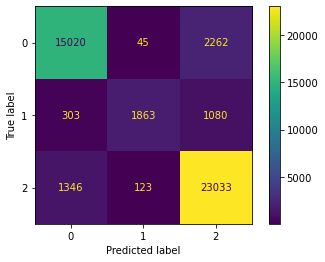

In [30]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=30, min_impurity_split=0.3, min_samples_split=2)
dt_model.fit(X_train_clean, y_train)
dt_model_pred = dt_model.predict(X_train_clean)

print("Training data model score:")
dt_model_score = model_score(dt_model, X_train_clean, dt_model_pred, y_train)

In [31]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=20)
random_forest.fit(X_train_clean, y_train)

#scores on folds
scores = cross_val_score(estimator=random_forest, X=X_train_clean, y=y_train, cv=5)
print(np.mean(scores))

#scores on on test
score = random_forest.score(X_test_clean, y_test)
print(score)

# grid search on random forest
# grid = {
#     'criterion' : ['entropy', 'gini'],
#     'max_depth': [5,10,15,20, None],
#     'min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3,0.4, 0.5], #values selected based on gini   
#     'min_impurity_split' : [None, 0.1, 0.2, 0.3, 0.4, 0.5], #values selected based on gini
#     'bootstrap' : [False, True] 
# }
# gs = GridSearchCV(estimator=random_forest , param_grid=grid, cv=5)
# gs.fit(X_train_clean, y_train)

# print(f'Best parameters are {gs.best_params_}')
# print(f'Best score {gs.best_score_}')
# print(f'Best estimator score {gs.best_estimator_.score(X_test_clean, y_test)}')

0.7977149195784803
0.8078800248469252


In [32]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=23)
random_forest.fit(X_train_clean, y_train)

#scores on folds
scores = cross_val_score(estimator=random_forest, X=X_train_clean, y=y_train, cv=5)
print(np.mean(scores))

#scores on on test
score = random_forest.score(X_test_clean, y_test)
print(score)

# grid search on random forest
# grid = {
#     'max_depth': [17, 19, 20, 23, 25, 27]
# }
# gs = GridSearchCV(estimator=random_forest , param_grid=grid, cv=5)
# gs.fit(X_train_clean, y_train)

# print(f'Best parameters are {gs.best_params_}')
# print(f'Best score {gs.best_score_}')
# print(f'Best estimator score {gs.best_estimator_.score(X_test_clean, y_test)}')

0.7994231835829173
0.8084124589582039


In [77]:
y_binary_test = label_binarize(y_test, classes=[0, 1, 2])

dt_model_pred_proba = dt_model.predict_proba(X_test_clean)
rf_model_pred_proba = random_forest.predict_proba(X_test_clean)
knn_model_pred_proba = knn_model.predict_proba(X_test_clean)
log_model_pred_proba = log_model.predict_proba(X_test_clean)
dummy_model_pred_proba = dummy.predict_proba(X_test_clean)

dt_test = roc_auc_score(y_binary_test, dt_model_pred_proba, multi_class='ovr')
rf_auc = roc_auc_score(y_binary_test, rf_model_pred_proba, multi_class='ovr')
knn_auc = roc_auc_score(y_binary_test, knn_model_pred_proba, multi_class='ovr')
log_model_auc = roc_auc_score(y_binary_test, log_model_pred_proba, multi_class='ovr')
dummy_auc = roc_auc_score(y_binary_test, dummy_model_pred_proba, multi_class='ovr')

print(f'The AUC score for our baseline model is: {round(dummy_auc, 4)}')
print(f'The AUC score for our decision tree model is: {round(dt_test, 4)}')
print(f'The AUC score for our random forest model is: {round(rf_auc, 4)}')
print(f'The AUC score for our k nearest neighbor model is: {round(knn_auc, 4)}')      
print(f'The AUC score for our logistic regression model is: {round(log_model_auc, 4)}')      

The AUC score for our baseline model is: 0.4968
The AUC score for our decision tree model is: 0.7556
The AUC score for our random forest model is: 0.9005
The AUC score for our k nearest neighbor model is: 0.8549
The AUC score for our logistic regression model is: 0.8305


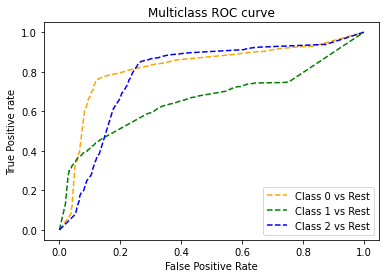

In [81]:
fig, ax = plt.subplots()

auc_list = [dt_test, rf_auc, knn_auc, log_model_auc, dummy_auc]

n_class = 3

fpr = {}
tpr = {}
thresh ={}

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, dt_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

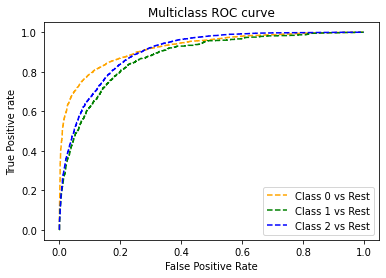

In [82]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, rf_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

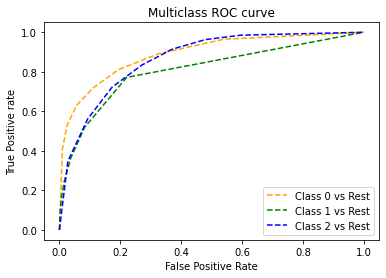

In [83]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, knn_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

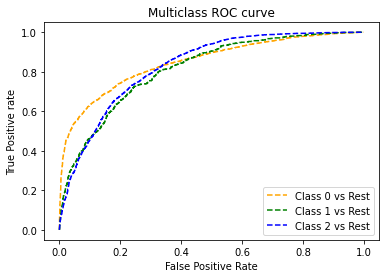

In [84]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, log_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

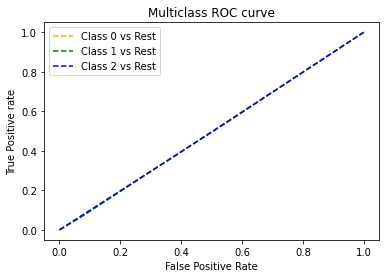

In [85]:
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, dummy_model_pred_proba[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 